In [13]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
def plt_roc_curve(all_test_labels, all_test_probs):
    # 1. Convert lists to numpy arrays first
    labels_array = np.array(all_test_labels)
    probs_array = np.array(all_test_probs)

    # 2. Flatten them to ensure they are 1D (removes that extra dimension)
    labels_flat = labels_array.flatten()
    probs_flat = probs_array.flatten()

    # After the loop finishes:
    fpr, tpr, thresholds = roc_curve(labels_flat, probs_flat)
    roc_auc = auc(fpr, tpr)

    # Plotting
    plt.figure(figsize=(7, 7))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # Random guess line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.title('Receiver Operating Characteristic (ROC) - MLP')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()

In [14]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def plt_confusion_matrix(all_test_labels, all_test_preds):
    # 1. Classification Report (Precision, Recall, F1)
    # 0 = TD, 1 = MLD
    target_names = ['Typical Development', 'Math Learning Difficulty']
    print("\nDetailed Classification Report:")
    print(classification_report(all_test_labels, all_test_preds, target_names=target_names))

    # 2. Confusion Matrix
    cm = confusion_matrix(all_test_labels, all_test_preds)

    # 3. Visualization
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=target_names, yticklabels=target_names)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix: MLP with LASSO (LOOCV)')
    plt.show()

In [15]:

from helper_lin import get_labels
def get_roi_names(index, n_rois=400):
    """Converts a vector index back to ROI pairs (Schaefer 400)."""
    # Create an empty upper triangle matrix
    tri_indices = np.triu_indices(n_rois, k=1)
    roi_a_idx = tri_indices[0][index]
    roi_b_idx = tri_indices[1][index]
    return roi_a_idx, roi_b_idx

def get_top_10_conn(feature_weights, selected_indices):
    # 3. Get the Top 10 Indices
    # argsort gives indices of features from smallest to largest weight
    # [-10:] takes the last 10 (the largest), and [::-1] puts them in descending order
    top_10_meta_indices = np.argsort(feature_weights)[-10:][::-1]

    # Map these meta-indices (0-99) back to the original connectivity indices (0-79799)
    # Assuming 'selected_indices' is the array from your SelectKBest step
    top_10_raw_indices = selected_indices[top_10_meta_indices]

    # 4. Print and Store Results
    print(f"--- Top 10 Connectivity Fingerprints ---")
    top_connections_info = []
    labels = get_labels()
    for i, raw_idx in enumerate(top_10_raw_indices):
        roi_a_idx, roi_b_idx = get_roi_names(raw_idx)
        
        label_a = (labels[roi_a_idx])
        label_b = (labels[roi_b_idx])
        score = feature_weights[top_10_meta_indices[i]]
        
        print(f"Rank {i+1}: Score {score:.4f} | {label_a} <-> {label_b}")
        
        top_connections_info.append({
            'rank': i+1,
            'score': score,
            'roi_a': label_a,
            'roi_b': label_b,
            'indices': (roi_a_idx, roi_b_idx)
        })
    return top_connections_info

In [16]:
from sklearn.model_selection import StratifiedKFold
import numpy as np
import xgboost as xgb
from helper_lin import get_all_data, get_mult_data, get_sub_data, get_labels
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler

X_avg, y_avg = get_all_data()
selector = SelectKBest(score_func=f_classif, k=100)
X_reduced = selector.fit_transform(X_avg, y_avg)
selected_indices = selector.get_support(indices=True)

# Scale the data 
scaler = StandardScaler()
X_final = scaler.fit_transform(X_reduced)
# Setup the fold strategy
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store scores
scores = []
all_y_test = []
all_y_probs = []
all_y_preds = []

# X and y are your NumPy arrays
for train_index, test_index in skf.split(X_final, y_avg):
    # Slice the NumPy arrays using the indices provided by SKF
    X_train, X_test = X_final[train_index], X_final[test_index]
    y_train, y_test = y_avg[train_index], y_avg[test_index]
    
    # Initialize and train
    model = xgb.XGBClassifier(n_estimators=100, verbosity=0)
    model.fit(X_train, y_train)
    
    # Get probabilities for AUC and hard predictions for Confusion Matrix
    probs = model.predict_proba(X_test)[:, 1] 
    preds = model.predict(X_test)
    
    all_y_test.extend(y_test)
    all_y_probs.extend(probs)
    all_y_preds.extend(preds)

    # Evaluate
    score = model.score(X_test, y_test)
    scores.append(score)

print(f"Mean Accuracy: {np.mean(scores):.4f}")

Mean Accuracy: 0.6333


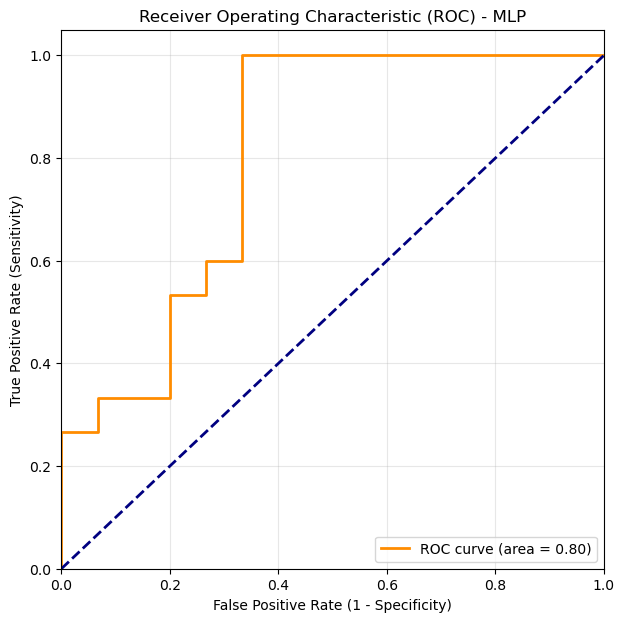

In [17]:
plt_roc_curve(all_y_test, all_y_probs)


Detailed Classification Report:
                          precision    recall  f1-score   support

     Typical Development       0.62      0.67      0.65        15
Math Learning Difficulty       0.64      0.60      0.62        15

                accuracy                           0.63        30
               macro avg       0.63      0.63      0.63        30
            weighted avg       0.63      0.63      0.63        30



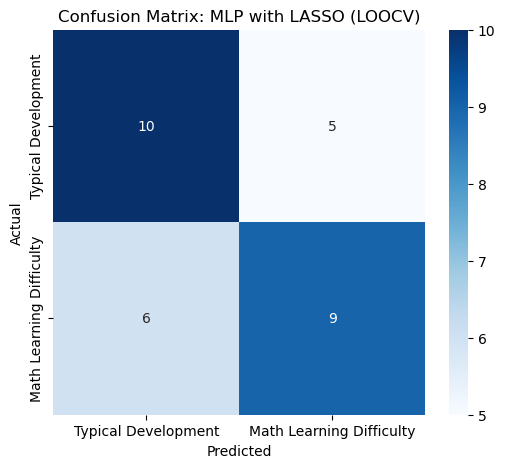

In [18]:
plt_confusion_matrix(all_y_test, all_y_preds)

In [19]:
feature_weights = model.feature_importances_
all_top_10_conn = get_top_10_conn(feature_weights, selected_indices)

--- Top 10 Connectivity Fingerprints ---
[fetch_atlas_schaefer_2018] Dataset found in /Users/jchong058/nilearn_data/schaefer_2018
Rank 1: Score 0.2893 | 7Networks_RH_SomMot_37 <-> 7Networks_RH_Limbic_OFC_5
Rank 2: Score 0.2378 | 7Networks_LH_Vis_16 <-> 7Networks_LH_Vis_29
Rank 3: Score 0.1627 | 7Networks_LH_DorsAttn_Post_6 <-> 7Networks_LH_Default_pCunPCC_3
Rank 4: Score 0.1028 | 7Networks_RH_SomMot_38 <-> 7Networks_RH_Cont_PFCl_8
Rank 5: Score 0.0703 | 7Networks_LH_SalVentAttn_Med_2 <-> 7Networks_RH_Vis_26
Rank 6: Score 0.0504 | 7Networks_LH_SomMot_16 <-> 7Networks_LH_Cont_PFCl_5
Rank 7: Score 0.0431 | 7Networks_LH_Vis_16 <-> 7Networks_LH_DorsAttn_Post_14
Rank 8: Score 0.0237 | 7Networks_LH_Default_Par_1 <-> 7Networks_RH_Vis_2
Rank 9: Score 0.0199 | 7Networks_LH_SalVentAttn_Med_3 <-> 7Networks_RH_DorsAttn_Post_11
Rank 10: Score 0.0000 | 7Networks_LH_Vis_12 <-> 7Networks_RH_Cont_pCun_1


In [20]:
import pandas as pd

# Convert the list of tensors to a flat numpy array
xgb_probs = np.array([p.item() for p in all_y_probs])
xgb_labels = np.array(all_y_test)

df_mlp = pd.DataFrame({
    'true_label': xgb_labels,
    'xgb_prob': xgb_probs
})
df_mlp.to_csv('preds/xgb_kfold_results.csv', index=False)